#ШАГ 1. Создание таблиц

##Создание таблицы customer

``` sql
create table customer (
	customer_id int primary key,
	first_name varchar(20) not null,
	last_name varchar(30),
	gender varchar(10) not null,
	DOB date,
	job_title varchar(50),
	job_industry_category varchar(50),
	wealth_segment varchar (30),
	deceased_indicator varchar(1) not null,
	owns_car varchar(3) not null,
	address varchar(50) not null,
	postcode int not null,
	state varchar(30) not null,
	country varchar(30) not null,
	property_valuation int not null
)
```
##Создание таблицы product
*В связи с неуникальностью product_id был сделан новый уникальный ключ new_product_id*
```sql
create table product (
    new_product_id int primary key,
	product_id int,
	brand varchar(20),
	product_line varchar(20),
	product_class varchar(6),
	product_size varchar(6),
	list_price decimal(6, 2) not null,
	standard_cost decimal(6, 2)
)
```
##Создание таблицы orders


```sql
create table orders (
	order_id int primary key,
	customer_id int not null,
	order_date date not null,
	online_order boolean,
	order_status varchar(9) not null
)

```

##Создание таблицы order_items

```sql
create table order_items (
	order_item_id int primary key,
	order_id int not null,
    new_product_id int not null,
	product_id int not null,
	quantity decimal(3, 1) not null,
	item_list_price_at_sale decimal(6, 2) not null,
	item_standard_cost_at_sale decimal(6, 2)
)
```








# ШАГ 2. Выполнение запросов

1. **Вывести все уникальные бренды, у которых есть хотя бы один продукт со стандартной стоимостью выше 1500 долларов, и суммарными продажами не менее 1000 единиц.**



```sql
select distinct brand
from product
inner join order_items on product.new_product_id = order_items.new_product_id
where standard_cost > 1500
group by brand
having sum(quantity) >= 1000
```
## Результат запроса
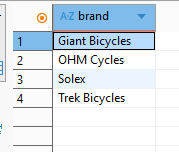



2. **Для каждого дня в диапазоне с 2017-04-01 по 2017-04-09 включительно вывести количество подтвержденных онлайн-заказов и количество уникальных клиентов, совершивших эти заказы.**



```sql
select order_date, count(*) as order_count,
    count(distinct customer_id) as unique_customers
from orders
where order_date between '2017-04-01' and '2017-04-09'
    and online_order = true
    and order_status = 'Approved'
group by order_date
```
## Результат запроса
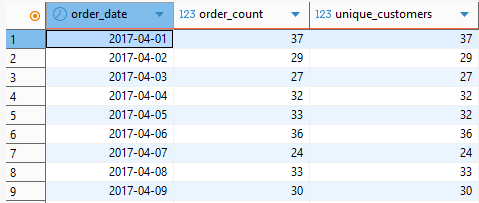

3. **Вывести профессии клиентов**:
  - **из сферы IT, чья профессия начинается с Senior;**
  - **из сферы Financial Services, чья профессия начинается с Lead.**

**Для обеих групп учитывать только клиентов старше 35 лет. Объединить выборки с помощью UNION ALL.**



```sql
select job_title, job_industry_category,
    extract(year from current_date) - extract(year from dob) as age
from customer
where job_industry_category = 'IT'
    and job_title like 'Senior%'
    and extract(year from current_date) - extract(year from dob) > 35

union all

select job_title, job_industry_category,
    extract(year from current_date) - extract(year from dob) as age
from customer
where job_industry_category = 'Financial Services'
    and job_title like 'Lead%'
    and extract(year from current_date) - extract(year from dob) > 35
order by job_industry_category, job_title
```
## Результат запроса
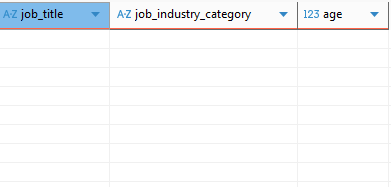


4. **Вывести бренды, которые были куплены клиентами из сферы Financial Services, но не были куплены клиентами из сферы IT.**


```sql
select distinct product.brand
from product
join order_items on product.new_product_id = order_items.new_product_id
join orders on order_items.order_id = orders.order_id
join customer on orders.customer_id = customer.customer_id
where customer.job_industry_category = 'Financial Services'

except

select distinct product.brand
from product
join order_items on product.new_product_id = order_items.new_product_id
join orders on order_items.order_id = orders.order_id
join customer on orders.customer_id = customer.customer_id
where customer.job_industry_category = 'IT'
```
## Результаты запроса
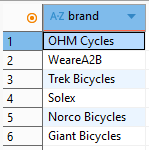

5. **Вывести 10 клиентов (ID, имя, фамилия), которые совершили наибольшее количество онлайн-заказов (в штуках) брендов Giant Bicycles, Norco Bicycles, Trek Bicycles, при условии, что они активны и имеют оценку имущества (property_valuation) выше среднего среди клиентов из того же штата.**



```sql
with state_avg_valuation as (
    select
        state,
        avg(property_valuation) as avg_val
    from customer
    where deceased_indicator = 'N'
    group by state
)
select customer_id, first_name, last_name,
    count(*) as order_count
from customer
join orders using (customer_id)
join order_items using (order_id)
join product using (new_product_id)
join state_avg_valuation using (state)
where online_order = true
    and brand in ('Giant Bicycles', 'Norco Bicycles', 'Trek Bicycles')
    and deceased_indicator = 'N'
    and property_valuation > avg_val
group by customer_id, first_name, last_name
order by order_count desc
limit 10
```
## Результат запроса

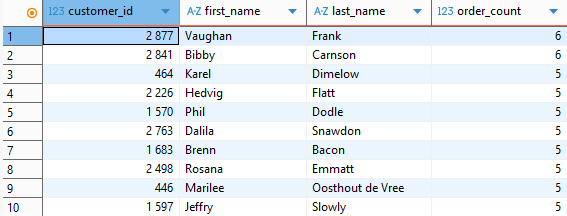


6. **Вывести всех клиентов (ID, имя, фамилия), у которых нет подтвержденных онлайн-заказов за последний год, но при этом они владеют автомобилем и их сегмент благосостояния не Mass Customer.**



```sql
select
    customer_id,
    first_name,
    last_name
from customer
where owns_car = 'Yes'
    and wealth_segment != 'Mass Customer'
    and customer_id not in (
        select distinct customer_id
        from orders
        where online_order = true
            and order_status = 'Approved'
            and order_date >= current_date - interval '1 year'
    )
order by customer_id
limit 15
```
## Результат запроса
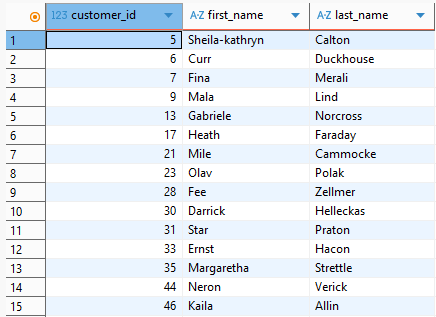



7. **Вывести всех клиентов из сферы 'IT' (ID, имя, фамилия), которые купили 2 из 5 продуктов с самой высокой list_price в продуктовой линейке Road.**



```sql
with top_road_products as (
    select product_id
    from product
    where product_line = 'Road'
    order by list_price desc
    limit 5
),
customer_purchases as (
    select
        customer.customer_id,
        customer.first_name,
        customer.last_name,
        count(distinct product.product_id) as bought_products_count
    from customer
    join orders on customer.customer_id = orders.customer_id
    join order_items on orders.order_id = order_items.order_id
    join product on order_items.new_product_id = product.new_product_id
    where customer.job_industry_category = 'IT'
        and product.product_id in (select product_id from top_road_products)
    group by customer.customer_id, customer.first_name, customer.last_name
)
select
    customer_id,
    first_name,
    last_name
from customer_purchases
where bought_products_count >= 2
order by customer_id
```
## Результат запроса
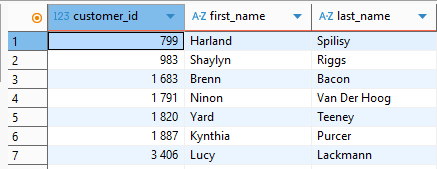


8. **Вывести клиентов (ID, имя, фамилия, сфера деятельности) из сфер IT или Health, которые совершили не менее 3 подтвержденных заказов в период 2017-01-01 по 2017-03-01, и при этом их общий доход от этих заказов превышает 10 000 долларов.
Разделить вывод на две группы (IT и Health) с помощью UNION.**



```sql
select
    customer.customer_id,
    customer.first_name,
    customer.last_name,
    customer.job_industry_category
from customer
join orders on customer.customer_id = orders.customer_id
join order_items on orders.order_id = order_items.order_id
where customer.job_industry_category = 'IT'
    and orders.order_status = 'Approved'
    and orders.order_date between '2017-01-01' and '2017-03-01'
group by customer.customer_id, customer.first_name, customer.last_name, customer.job_industry_category
having count(distinct orders.order_id) >= 3
    and sum(order_items.item_list_price_at_sale) > 10000

union

select
    customer.customer_id,
    customer.first_name,
    customer.last_name,
    customer.job_industry_category
from customer
join orders on customer.customer_id = orders.customer_id
join order_items on orders.order_id = order_items.order_id
where customer.job_industry_category = 'Health'
    and orders.order_status = 'Approved'
    and orders.order_date between '2017-01-01' and '2017-03-01'
group by customer.customer_id, customer.first_name, customer.last_name, customer.job_industry_category
having count(distinct orders.order_id) >= 3
    and sum(order_items.item_list_price_at_sale) > 10000
order by job_industry_category, customer_id
```
## Результат запроса
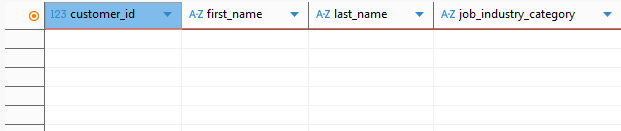
